In [74]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import fft, ifft
from scipy.integrate import simps

### 1. Data Prep

In [75]:
# Import Raw Counts Data
ebird19counts = pq.read_table("data/eb19_raw_counts_all.parquet").to_pandas().reset_index()
ebird22counts = pq.read_table("data/eb22_raw_counts_all.parquet").to_pandas().reset_index()
inat19counts = pq.read_table("data/in19_raw_counts_all.parquet").to_pandas().reset_index()
inat22counts = pq.read_table("data/in22_raw_counts_all.parquet").to_pandas().reset_index()

birdids_df = pd.read_csv("data/birdids.csv")
birdids = birdids_df['x'].tolist()

# dictionary & traits
bird_dict = pd.read_pickle("data/name_aviD_dict_22.pickle")
trait_data = pd.read_csv("data/AVONET1_BirdLife.csv")

# process trait data
# isolate avibaseID
trait_data['AVIBASE'] = trait_data['Avibase.ID1'].apply(lambda x: x.split('-')[1])

# Filter to 260 Birds
ebird19counts = ebird19counts[ebird19counts['AVIBASEID'].isin(birdids)]
inat19counts = inat19counts[inat19counts['AVIBASEID'].isin(birdids)]
ebird22counts = ebird22counts[ebird22counts['AVIBASEID'].isin(birdids)]
inat22counts = inat22counts[inat22counts['AVIBASEID'].isin(birdids)]

In [76]:
# Combine into one DataFrame and add a 'yr_db' key
count_list = [
    ('ebird19', ebird19counts),
    ('inat19', inat19counts),
    ('ebird22', ebird22counts),
    ('inat22', inat22counts)
]

allcounts = pd.concat(
    [df.assign(yr_db=name) for name, df in count_list],
    ignore_index=True
)

In [77]:
# Filter to separate the combined DataFrame into the original DataFrames
ebird19counts = allcounts[allcounts['yr_db'] == 'ebird19']
ebird22counts = allcounts[allcounts['yr_db'] == 'ebird22']
inat19counts = allcounts[allcounts['yr_db'] == 'inat19']
inat22counts = allcounts[allcounts['yr_db'] == 'inat22'] 

In [78]:
ebird19counts.head(5)

,AVIBASEID,Week-1,Week-2,Week-3,Week-4,Week-5,Week-6,Week-7,Week-8,Week-9,...,Week-44,Week-45,Week-46,Week-47,Week-48,Week-49,Week-50,Week-51,Week-52,yr_db
0,00124D98,1545.0,1202.0,896.0,1309.0,1093.0,1132.0,1143.0,1295.0,1063.0,...,873.0,836.0,1005.0,906.0,836.0,886.0,1276.0,1070.0,1184.0,ebird19
1,00635FF9,59.0,32.0,40.0,61.0,22.0,28.0,38.0,65.0,16.0,...,45.0,74.0,70.0,55.0,24.0,22.0,67.0,33.0,55.0,ebird19
2,01060BFD,229.0,186.0,101.0,234.0,97.0,164.0,124.0,184.0,88.0,...,211.0,247.0,174.0,189.0,169.0,153.0,172.0,102.0,155.0,ebird19
3,018B3169,374.0,342.0,225.0,380.0,275.0,240.0,241.0,352.0,218.0,...,162.0,230.0,189.0,196.0,204.0,202.0,292.0,141.0,245.0,ebird19
4,029491CD,0.0,1.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,...,1.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,ebird19


#### 1.1 Unsmoothed Data

In [79]:
# Define the function to convert counts to relative counts
def counts_to_relative(df):
    df_relative = df.copy()
    df_relative.iloc[:, 1:53] = df.iloc[:, 1:53].div(df.iloc[:, 1:53].sum(axis=1), axis=0)
    return df_relative

# Apply the function to each DataFrame
ebird19rel = counts_to_relative(ebird19counts)
ebird22rel = counts_to_relative(ebird22counts)
inat19rel = counts_to_relative(inat19counts)
inat22rel = counts_to_relative(inat22counts)

In [80]:
ebird19rel.head(5)

,AVIBASEID,Week-1,Week-2,Week-3,Week-4,Week-5,Week-6,Week-7,Week-8,Week-9,...,Week-44,Week-45,Week-46,Week-47,Week-48,Week-49,Week-50,Week-51,Week-52,yr_db
0,00124D98,0.022217,0.017285,0.012884,0.018823,0.015717,0.016278,0.016436,0.018622,0.015286,...,0.012554,0.012022,0.014452,0.013028,0.012022,0.012741,0.018349,0.015386,0.017026,ebird19
1,00635FF9,0.014224,0.007715,0.009643,0.014706,0.005304,0.006750,0.009161,0.015670,0.003857,...,0.010849,0.017840,0.016876,0.013259,0.005786,0.005304,0.016152,0.007956,0.013259,ebird19
2,01060BFD,0.021075,0.017118,0.009295,0.021535,0.008927,0.015093,0.011412,0.016934,0.008099,...,0.019418,0.022731,0.016013,0.017394,0.015553,0.014081,0.015829,0.009387,0.014265,ebird19
3,018B3169,0.062974,0.057585,0.037885,0.063984,0.046304,0.040411,0.040579,0.059269,0.036707,...,0.027277,0.038727,0.031824,0.033002,0.034349,0.034012,0.049167,0.023741,0.041253,ebird19
4,029491CD,0.000000,0.004149,0.000000,0.000000,0.008299,0.000000,0.000000,0.008299,0.000000,...,0.004149,0.012448,0.000000,0.000000,0.016598,0.000000,0.000000,0.000000,0.000000,ebird19


In [81]:
# Save unsmoothed relative data
ebird19rel.to_csv("data/ebird19rel_raw.csv", index=False)
ebird22rel.to_csv("data/ebird22rel_raw.csv", index=False)
inat19rel.to_csv("data/inat19rel_raw.csv", index=False)
inat22rel.to_csv("data/inat22rel_raw.csv", index=False)

#### 1.2 Smoothed Data

In [82]:
# Define the Fourier smoothing function
def four_smooth(df_relative, k=3):

    # Establish time grid
    t = np.arange(1, 53)

    # Extract relevant data
    avibaseid = df_relative.iloc[:, 0]  # avibaseid
    database = df_relative.iloc[:, -1]  # yr_db
    y = df_relative.iloc[:, 1:53].values  # Weekly data
    
    # Fourier transform
    y_fft = fft(y, axis=1)
    
    # Keep only the first k frequencies (low-pass filter)
    y_fft[:, k+1:-k] = 0
    
    # Inverse Fourier transform to get the smoothed data
    smoothed = ifft(y_fft, axis=1).real
    
    # Prevent negatives
    smoothed = np.maximum(smoothed, 0.001)
    
    # Renormalize
    dens = smoothed
    for i in range(smoothed.shape[0]):
        dens[i, :] = smoothed[i, :] / simps(smoothed[i, :], t)
    
    df_dens = pd.DataFrame(dens, columns=df_relative.columns[1:53])
    
    # Combine the database and avibaseid with the smoothed densities
    output = pd.concat([avibaseid.reset_index(drop=True), df_dens, database.reset_index(drop=True)], axis=1)
    
    return output

# Smooth with 8-dim basis
ebird19rel_smoothed = four_smooth(df_relative=ebird19rel, k=8)
ebird22rel_smoothed = four_smooth(df_relative=ebird22rel, k=8)
inat19rel_smoothed = four_smooth(df_relative=inat19rel, k=8)
inat22rel_smoothed = four_smooth(df_relative=inat22rel, k=8)

In [83]:
ebird19rel_smoothed.head(5)

,AVIBASEID,Week-1,Week-2,Week-3,Week-4,Week-5,Week-6,Week-7,Week-8,Week-9,...,Week-44,Week-45,Week-46,Week-47,Week-48,Week-49,Week-50,Week-51,Week-52,yr_db
0,00124D98,0.018694,0.018123,0.017248,0.016527,0.016228,0.016368,0.016810,0.017410,0.018115,...,0.012763,0.012823,0.012809,0.012868,0.013341,0.014439,0.016005,0.017555,0.018545,ebird19
1,00635FF9,0.011543,0.011329,0.011038,0.010335,0.009128,0.007936,0.007630,0.008694,0.010716,...,0.017396,0.016030,0.013276,0.010637,0.009383,0.009683,0.010722,0.011530,0.011723,ebird19
2,01060BFD,0.016035,0.017505,0.017243,0.015215,0.012796,0.011688,0.012425,0.013763,0.013619,...,0.019816,0.018787,0.017796,0.017048,0.016186,0.014918,0.013609,0.013147,0.014115,ebird19
3,018B3169,0.054106,0.056628,0.055648,0.052839,0.050209,0.048651,0.047581,0.045803,0.042708,...,0.025445,0.033208,0.037910,0.038558,0.036512,0.034788,0.036134,0.041221,0.048224,ebird19
4,029491CD,0.001588,0.002693,0.002342,0.001216,0.000992,0.002321,0.004600,0.005497,0.003403,...,0.002670,0.004967,0.007028,0.007544,0.006002,0.003057,0.000992,0.000992,0.000992,ebird19


In [84]:
# Save Fourier smoothed data
ebird19rel_smoothed.to_csv("data/ebird19rel_fsmoothed.csv", index=False)
ebird22rel_smoothed.to_csv("data/ebird22rel_fsmoothed.csv", index=False)
inat19rel_smoothed.to_csv("data/inat19rel_fsmoothed.csv", index=False)
inat22rel_smoothed.to_csv("data/inat22rel_fsmoothed.csv", index=False)

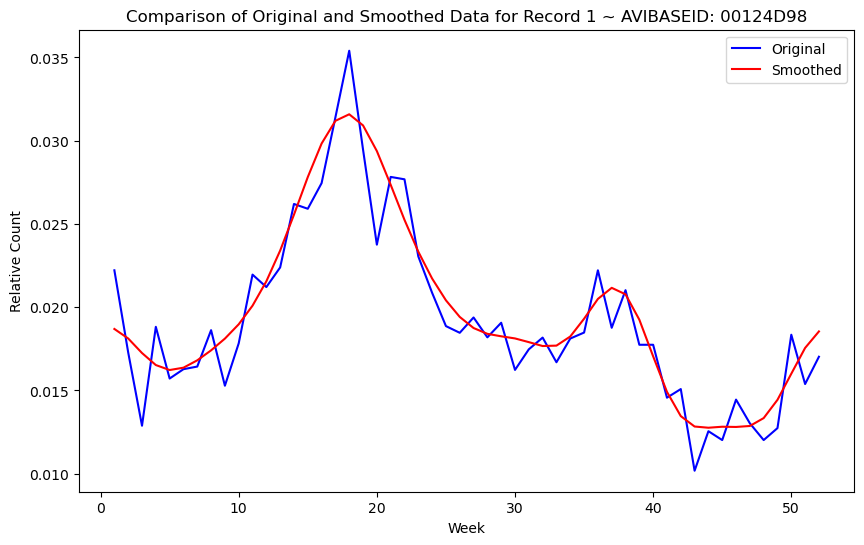

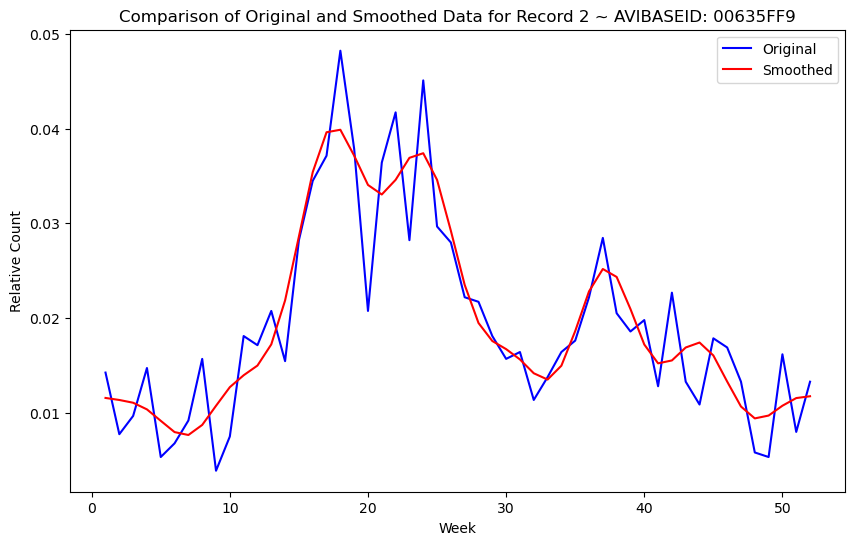

In [85]:
# Function to plot comparisons
def plot_comparison(original_df, smoothed_df, num_plots=10):
    t = np.arange(1, 53) 
    for i in range(num_plots):
        plt.figure(figsize=(10, 6))
        plt.plot(t, original_df.iloc[i, 1:53], label='Original', color='blue')
        plt.plot(t, smoothed_df.iloc[i, 1:53], label='Smoothed', color='red')
        plt.xlabel('Week')
        plt.ylabel('Relative Count')
        plt.title(f'Comparison of Original and Smoothed Data for Record {i+1} ~ AVIBASEID: {original_df["AVIBASEID"][i]}')
        plt.legend()
        plt.show()

plot_comparison(ebird19rel, ebird19rel_smoothed, num_plots=2)


#### 1.3 Long Format

In [86]:
def make_long(df):
    # Pivoting the DataFrame from wide to long format
    dflong = df.melt(id_vars=['AVIBASEID', 'yr_db'], 
                     var_name='week', 
                     value_name='count')
    
    # Removing the 'Week-' prefix and converting the 'week' column to numeric
    dflong['week'] = dflong['week'].str.replace('Week-', '').astype(int)
    
    return dflong

In [87]:
# Transforming the smoothed data to long format
ebird19rel_smoothed_long = make_long(ebird19rel_smoothed)
ebird22rel_smoothed_long = make_long(ebird22rel_smoothed)
inat19rel_smoothed_long = make_long(inat19rel_smoothed)
inat22rel_smoothed_long = make_long(inat22rel_smoothed)

In [88]:
# Combining all long format data into one DataFrame
allbirdsrel_smoothed_long = pd.concat([ebird19rel_smoothed_long,
                                       ebird22rel_smoothed_long,
                                       inat19rel_smoothed_long,
                                       inat22rel_smoothed_long], 
                                      ignore_index=True)

In [89]:
allbirdsrel_smoothed_long.head(5)

,AVIBASEID,yr_db,week,count
0,00124D98,ebird19,1,0.018694
1,00635FF9,ebird19,1,0.011543
2,01060BFD,ebird19,1,0.016035
3,018B3169,ebird19,1,0.054106
4,029491CD,ebird19,1,0.001588


### 2. Data Visualization

#### 2.1 Individual Plots

In [90]:
def ggcirc(i, circular=False, scalefix=False):
    # Filter the DataFrame for the selected bird ID
    bird_id = birdids[i]
    df_filtered = allbirdsrel_smoothed_long[allbirdsrel_smoothed_long['AVIBASEID'] == bird_id].copy()

    # Match bird ID to common name
    common_name = bird_dict[bird_id]
    
    # Duplicate the data point for week 1 and append it to the end of the DataFrame (needed to make smooth circle)
    week_1_data = df_filtered[df_filtered['week'] == 1].copy()
    week_1_data['week'] = 53  # Create a week 53
    df_filtered = pd.concat([df_filtered, week_1_data], ignore_index=True)
    
    # Define color coding schemes
    rects = [
        (0, 9, '#B983FF'),
        (9, 9+13, '#00BA38'),
        (22, 35, '#A3A500'),
        (35, 48, '#E58700'),
        (48, 52, '#B983FF')
    ]
    colors = ['#e98b81', '#a4c062', '#56bcc2', '#c188f8']  # Line colors

    # Plotting the data

    if circular:
        # Recalculate the week_rad for polar coordinates
        df_filtered['week_rad'] = df_filtered['week'] * 2 * np.pi / 52

        # Create the circular plot
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 6))

        # Set the starting angle of the polar plot to 90 degrees and make it go clockwise
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)

        # Colored arcs
        for start_week, end_week, color in rects:
            start_rad = start_week * 2 * np.pi / 52
            end_rad = end_week * 2 * np.pi / 52
            ax.fill_between([start_rad, end_rad], 0, 1, color=color, alpha=0.2)

        # Line Plots
        sns.lineplot(data=df_filtered, x='week_rad', y='count', hue='yr_db', ax=ax, linewidth=3, palette=colors)

        # Add a dashed line at 1/52
        ax.plot(np.linspace(0, 2 * np.pi, 100), [1/52] * 100, color='grey', linestyle='dashed', linewidth=2)
        
        if scalefix:
            ax.set_ylim(0, 0.12)
        else:
            ax.set_ylim(0, df_filtered['count'].max() * 1.2)
        
        # Set x-ticks to correspond to every 4th week
        week_ticks = np.arange(0, 2 * np.pi, 2 * np.pi / 52 * 4)
        week_labels = np.arange(1, 53, 4)
        ax.set_xticks(week_ticks)
        ax.set_xticklabels(week_labels)

    else:
        # Create the base plot
        fig, ax = plt.subplots(figsize=(10, 6))

        # Add a dashed line at 1/52
        ax.axhline(y=1/52, color='grey', linestyle='dashed', linewidth=2)
        for xmin, xmax, color in rects:
            ax.axvspan(xmin, xmax, color=color, alpha=0.2)

        # Plot line graph
        sns.lineplot(data=df_filtered, x='week', y='count', hue='yr_db', ax=ax, linewidth=3, palette=colors)

        ax.set_aspect('auto')  # Changed from Cody's
        ax.set_xlim(1, 52)
        if scalefix:
            ax.set_ylim(0, 0.12)

    # For both
    ax.set_title(common_name, fontsize=20)
    plt.xlabel('Week')
    plt.ylabel('Frequency')
    plt.grid(True)

    # Place the legend to the right of the graph
    ax.legend(title='Database/Year', loc='upper left', bbox_to_anchor=(1.1, 0.7))

    plt.show()

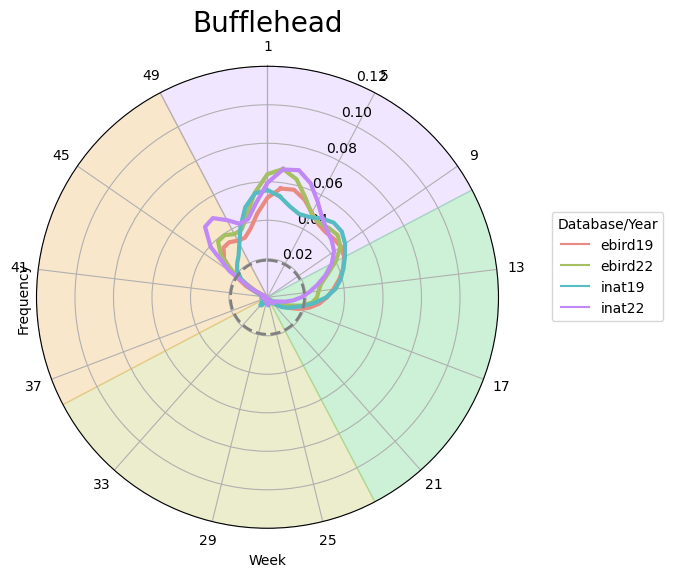

In [91]:
# Example usage:
ggcirc(9, circular=True, scalefix=True)

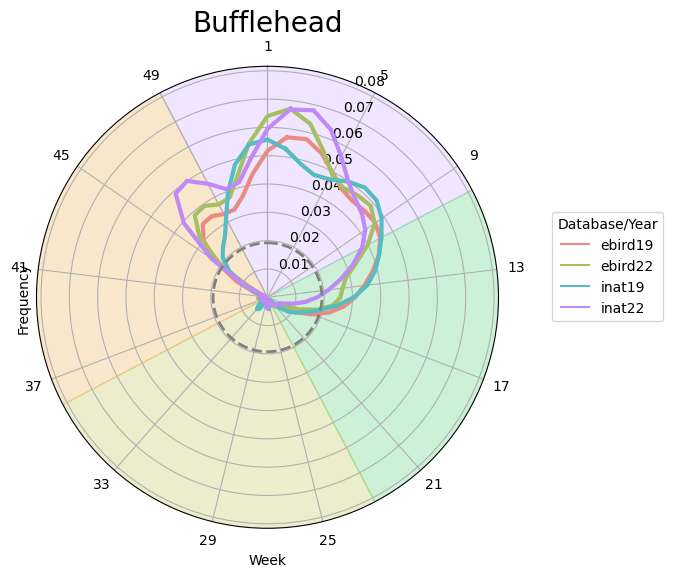

In [92]:
# Example usage:
ggcirc(9, circular=True, scalefix=False)


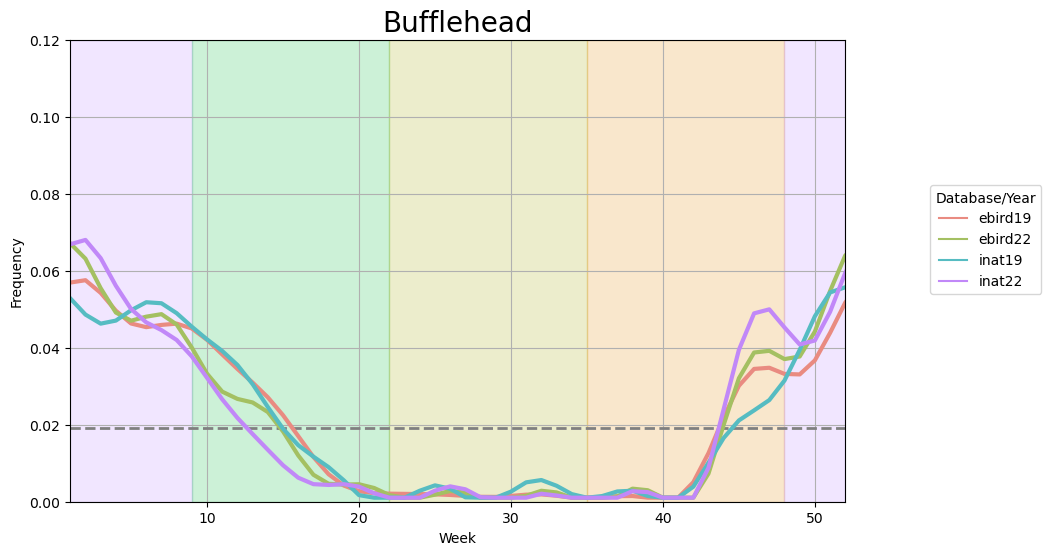

In [93]:
# Example usage:
ggcirc(9, circular=False, scalefix=True)


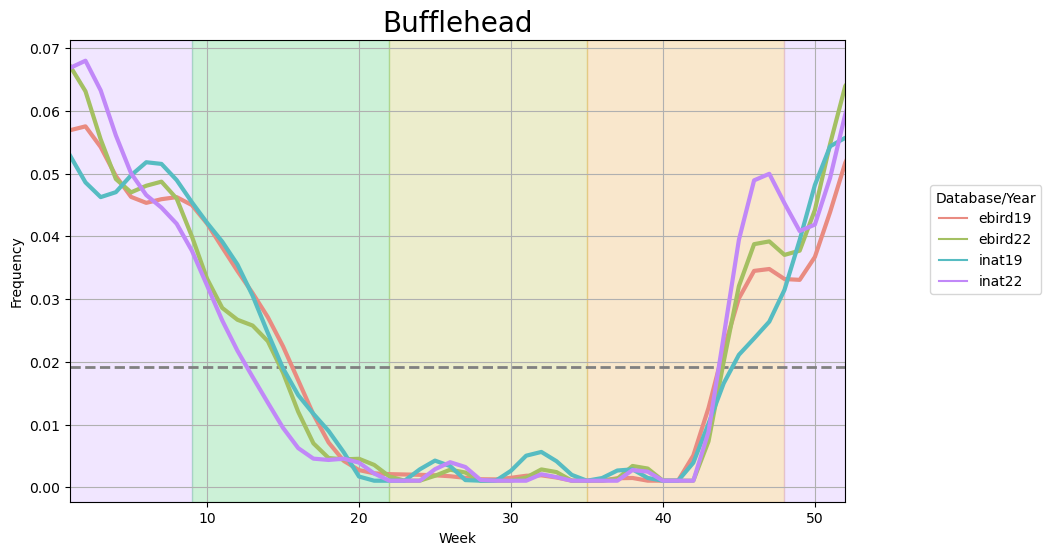

In [94]:
# Example usage:
ggcirc(9, circular=False, scalefix=False)


#### 2.2 Side by Side Plots

In [95]:
def sidebysideplot(i, scalefix=False):
    bird_id = birdids[i]
    df_filtered = allbirdsrel_smoothed_long[allbirdsrel_smoothed_long['AVIBASEID'] == bird_id].copy()

    # Duplicate the data point for week 1 and append it to the end of the DataFrame
    week_1_data = df_filtered[df_filtered['week'] == 1].copy()
    week_1_data['week'] = 53  # Create a week 53 to seamlessly wrap around
    df_filtered = pd.concat([df_filtered, week_1_data], ignore_index=True)

    # Match bird ID to common name
    common_name = bird_dict[bird_id]

    # Define color coding schemes
    rects = [
        (0, 9, '#B983FF'),
        (9, 9+13, '#00BA38'),
        (22, 35, '#A3A500'),
        (35, 48, '#E58700'),
        (48, 52, '#B983FF')
    ]
    colors = ['#e98b81', '#a4c062', '#56bcc2', '#c188f8']  # Line colors

    # Define figure
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))

    # Plot rectangle - axes[0]

    ax[0].axhline(y=1/52, color='grey', linestyle='dashed', linewidth=2)
    for xmin, xmax, color in rects:
        ax[0].axvspan(xmin, xmax, color=color, alpha=0.2)
    # Plot line graph
    sns.lineplot(data=df_filtered, x='week', y='count', hue='yr_db', ax=ax[0], linewidth=3, palette=colors)
    ax[0].set_aspect('auto')  # Changed from Cody's
    ax[0].set_xlim(1, 52)
    if scalefix:
        ax[0].set_ylim(0, 0.12)
    ax[0].get_legend().remove()

    # Plotting the circular data - axes[0]

    # Hide the rectangular box around the circular plot
    ax[1].set_frame_on(False)
    ax[1].set_yticks([])
    ax[1].set_xticks([])

    # Recalculate the week_rad to wrap around correctly
    df_filtered['week_rad'] = df_filtered['week'] * 2 * np.pi / 52

    ax[1] = fig.add_subplot(122, projection='polar')  # Set to polar coordinates
    ax[1].set_theta_zero_location('N')  # Set to start at top
    ax[1].set_theta_direction(-1)  # Set to order clockwise

    # Colored arcs
    for start_week, end_week, color in rects:
        start_rad = start_week * 2 * np.pi / 52
        end_rad = end_week * 2 * np.pi / 52
        ax[1].fill_between([start_rad, end_rad], 0, 1, color=color, alpha=0.2)

    # Plotting the data
    sns.lineplot(data=df_filtered, x='week_rad', y='count', hue='yr_db', ax=ax[1], linewidth=3, palette=colors)
    # Add a dashed line at 1/52
    ax[1].plot(np.linspace(0, 2 * np.pi, 100), [1/52] * 100, color='grey', linestyle='dashed', linewidth=2)

    if scalefix:
        ax[1].set_ylim(0, 0.12)
    else:
        ax[1].set_ylim(0, df_filtered['count'].max() * 1.2)

    # Set x-ticks to correspond to every 4th week
    week_ticks = np.arange(0, 2 * np.pi, 2 * np.pi / 52 * 4)
    week_labels = np.arange(1, 53, 4)
    ax[1].set_xticks(week_ticks)
    ax[1].set_xticklabels(week_labels)

    # Legend
    ax[1].legend(title='Database/Year', loc='upper left', bbox_to_anchor=(1.2, 0.7), fontsize=14, title_fontsize=16)

    # Set common properties for both plots
    for a in ax:
        a.set_xlabel('Week')
        a.set_ylabel('Frequency')
        a.grid(True)
        a.set_title(common_name, fontsize=20)

    plt.show()

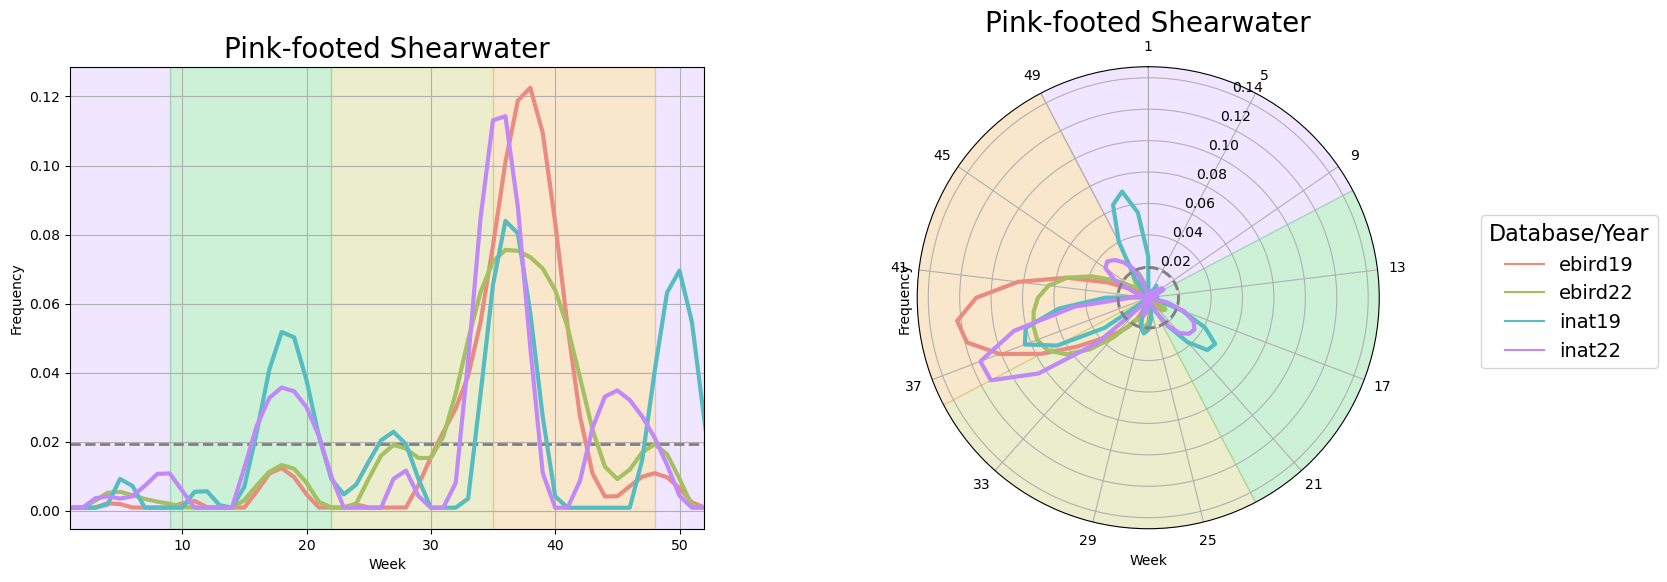

In [96]:
sidebysideplot(3, scalefix=False)

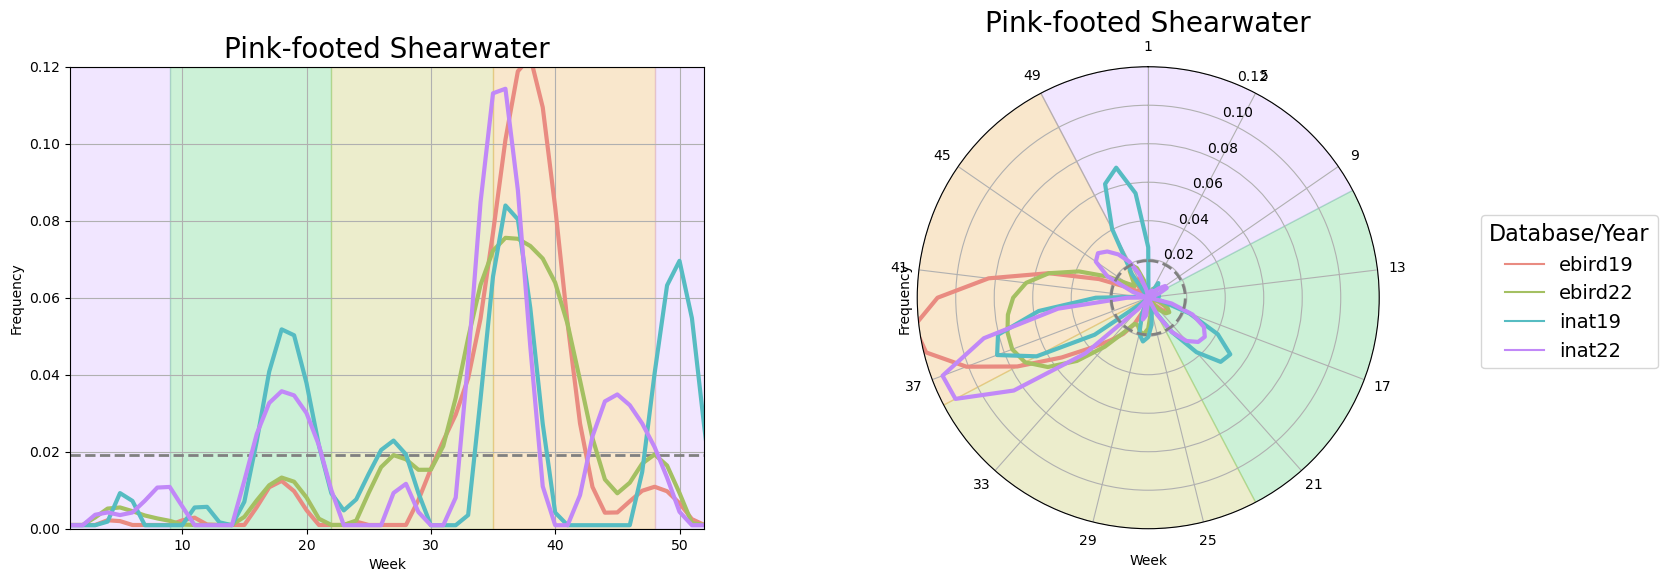

In [97]:
sidebysideplot(3, scalefix=True)

### 3. ToDo

Create and host a website/github which allows you to display these side by side plots for a selected bird. 
- Make a **dropdown bar** of the 260 birds available in this dataset that the user can scroll thru and select. 
- Allow for options to switch **scalefix on/off** 
- Allow for options to compare only **specific dbs/years** 
- Allow for settings to plot the **smoothed/unsmoothed curves**
- Allow for the user to select **multiple birds** at a time to facilitate comparisons. 